In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

In [3]:
!cp -r '$root/utils' .

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import nltk
import pickle
import keras
import string
import re

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from scipy.sparse import hstack

from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# prepare data

In [6]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv')
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [14]:
def map_special_strings(column):
    token_encoding = {
            ':)': 'xxsmilingfacexx',
            ':]': 'xxsmilingfacexx',
            ':-)': 'xxsmilingfacexx',
            ';)': 'xxwinksmilingfacexx',
            ':(': 'xxsadfacexx',
            ':-(': 'xxsadfacexx',
            ';(': 'xxcryingsadfacexx',
            ':|': 'xxblankfacexx',
            ':o': 'xxsurprisedfacexx',
            ':/': 'xxwryfacexx',
            ':D': 'xxgrinfacexx',
            ';D': 'xxwinkgrinfacexx',
            ':P': 'xxtonguefacexx',
            ':p': 'xxtongueface2xx',
            ';p': 'xxtongueface2xx',
            '<3': 'xxheartxx'
    }

    column = (column
        .str.replace(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', 'xxurlxx', regex=True)
        .str.replace(r'\bu/\w+', 'xxuserxx', regex=True)
        .str.replace(r'\br/\w+', 'xxsubredditmentionxx', regex=True)
        .str.replace(r'#[a-z0-9_]+', ' xxhashtagxx ', regex=True)
    )

    for token, encoding in token_encoding.items():
        pattern = re.compile(r'{}+(?!\S)'.format(re.escape(token)))
        column = column.str.replace(pattern, fr' {encoding} ', regex=True)

    column = (column
        .str.replace(r'[-+]?[.\d]*[\d]+[:,.\d]*', 'xxnumberxx', regex=True)
        .str.replace(r'\b(\S*?)(.)\2{2,}\b', r'\1\2 xxelongxx ', regex=True)
        .str.replace(r"(\b[^a-z0-9\W()<>'`\-]{2,}\b)", r'\1 xxallcapsxx ', regex=True)
    )

    return column

In [15]:
df['comment'] = map_special_strings(df['comment'])
df['parent_comment'] = map_special_strings(df['parent_comment'])

In [16]:
X = df[['comment', 'parent_comment']]
y = df['label'].values

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((768187, 2), (202155, 2), (40431, 2))

In [19]:
def sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [37]:
def vectorize_data(data, min_df=50):
    all_sw = list(sklear_stopwords) + stopwords.words('english')
    count_vectorizer = CountVectorizer(stop_words=all_sw, token_pattern=r'(?u)\b\w\w+\b|\!|\?|\.\.\.',
                                       ngram_range=(1,3), min_df=min_df)

    vec_data = {}
    vec_data['train'] = count_vectorizer.fit_transform(data[0])
    vec_data['val'] = count_vectorizer.transform(data[1])
    vec_data['test'] = count_vectorizer.transform(data[2])

    print('number of features: ', len(count_vectorizer.get_feature_names_out()))

    return count_vectorizer, vec_data

# no context
11.04.2022

In [38]:
count_vectorizer, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])

number of features:  11463


In [29]:
mnb = MultinomialNB()
mnb.fit(vec_data['train'], y_train);

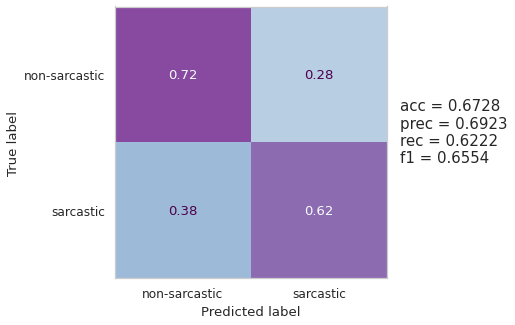

In [30]:
evaluate(mnb, vec_data['val'], y_val)

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(vec_data['train']), y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(vec_data['val']), y_val)).batch(128)

In [32]:
model = Sequential([
    InputLayer(input_shape=(vec_data['train'].shape[1],)),
    Dense(100, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    BatchNormalization(),
    Dense(100, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


6002/6002 [==============================] - 92s 14ms/step - loss: 0.6730 - accuracy: 0.6666 - val_loss: 0.6485 - val_accuracy: 0.6800
Epoch 2/50
6002/6002 [==============================] - 91s 15ms/step - loss: 0.6369 - accuracy: 0.6819 - val_loss: 0.6205 - val_accuracy: 0.6871
Epoch 3/50
6002/6002 [==============================] - 66s 11ms/step - loss: 0.6129 - accuracy: 0.6886 - val_loss: 0.6040 - val_accuracy: 0.6886
Epoch 4/50
6002/6002 [==============================] - 67s 11ms/step - loss: 0.6007 - accuracy: 0.6928 - val_loss: 0.6001 - val_accuracy: 0.6893
Epoch 5/50
6002/6002 [==============================] - 67s 11ms/step - loss: 0.5962 - accuracy: 0.6943 - val_loss: 0.5984 - val_accuracy: 0.6903
Epoch 6/50
6002/6002 [==============================] - 66s 11ms/step - loss: 0.5943 - accuracy: 0.6954 - val_loss: 0.5983 - val_accuracy: 0.6909
Epoch 7/50
6002/6002 [==============================] - 65s 11ms/step - loss: 0.5936 - accuracy: 0.6959 - val_loss: 0.5988 - val_accura

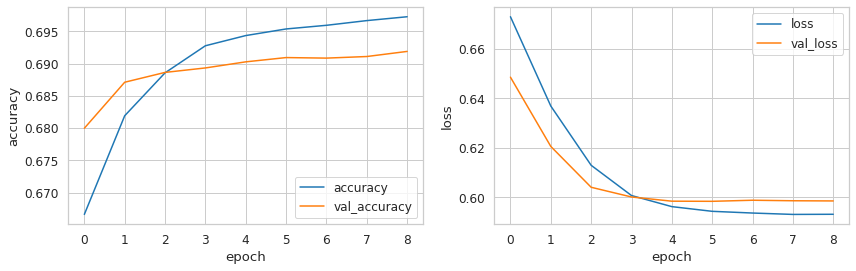

In [33]:
plot_history(fit)

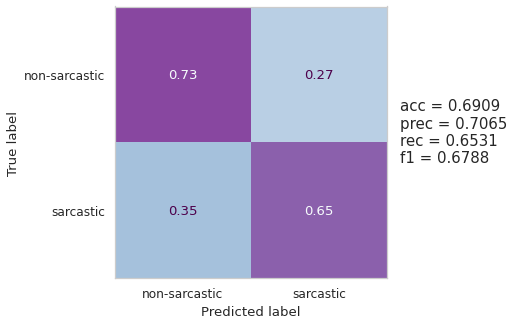

In [34]:
evaluate(model, sparse_tensor(vec_data['val']), y_val)

In [35]:
show_errors(model, X_val['comment'].values, sparse_tensor(vec_data['val']), y_val)

False negatives:
---------------------------
Use TOR xxallcapsxx  to update your Facebook page then?
Fucking love magical emp attacks that have discretionary targetting.
Is this just a repost of the article written at the end of every season of Downton Abbey?
Yeah Turkey's been genociding a lot of people recently
Because I've got mine.

False positives:
---------------------------
expensive doesn't always mean bad.. if you have the isk why not haha
Oh, childhood just got a bit ruined with this little factoid.
You can prove this aren't factory cut because he sells them on facebook groups.
He got in a fight with Steve Smith, He tweeted nasty things and a pic to tom brady after a win.
Lucky, I've never gotten a slab drop.


In [36]:
model.save(root+'models/bag_of_words')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/bag_of_words/assets


# univariate feature selection
11.04.2022

In [39]:
def univariate_fs(scorer, data_filename, scores_filename, k=4000):
    kbest = SelectKBest(scorer, k=k)

    X_train = kbest.fit_transform(vec_data['train'], y_train)
    X_val = kbest.transform(vec_data['val'])
    X_test = kbest.transform(vec_data['test'])

    data = {'X_train': X_train, 'X_val': X_test, 'X_test': X_test}

    with open(root+'univariate_fs/'+data_filename, 'wb') as file:
        pickle.dump(data, file)

    df_scores = pd.DataFrame({
        'feature': count_vectorizer.get_feature_names_out(),
        'score': kbest.scores_
    })
    
    df_scores = df_scores.sort_values('score', ascending=False, ignore_index=True)
    df_scores.to_csv(root+fr'univariate_fs/{scores_filename}.csv', index=False)

    return df_scores

## chi2

In [40]:
chi2_scores = univariate_fs(chi2, 'chi2_data', 'chi2_scores')

In [41]:
chi2_scores.head(20)

,feature,score
0,!,13340.238409
1,yeah,10195.156949
2,obviously,4936.548142
3,forgot,4382.854804
4,totally,3946.895838
5,clearly,3160.668544
6,xxallcapsxx xxallcapsxx,2696.465427
7,racist,1977.263443
8,right,1671.863524
9,yes,1618.525971


## anova f-value

In [42]:
f_scores = univariate_fs(f_classif, 'f_data', 'f_scores')

In [43]:
f_scores.head(20)

,feature,score
0,!,14153.919237
1,yeah,10677.091956
2,obviously,4986.986626
3,forgot,4442.318787
4,totally,3915.020091
5,clearly,3163.763582
6,racist,1876.004439
7,right,1646.488584
8,wow,1591.267205
9,yes,1575.596884


# context
11.04.2022

In [44]:
_, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])
_, vec_data_par = vectorize_data([X_train['parent_comment'], X_val['parent_comment'], X_test['parent_comment']])

number of features:  11463
number of features:  23435


In [45]:
X_train_vec = hstack([vec_data['train'], vec_data_par['train']])
X_val_vec = hstack([vec_data['val'], vec_data_par['val']])
X_test_vec = hstack([vec_data['test'], vec_data_par['test']])

In [50]:
train_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_train_vec), y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_val_vec), y_val)).batch(128)

In [51]:
model = Sequential([
    InputLayer(input_shape=(X_train_vec.shape[1],)),
    Dense(100, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    BatchNormalization(),
    Dense(100, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


6002/6002 [==============================] - 86s 14ms/step - loss: 0.7426 - accuracy: 0.6609 - val_loss: 0.7004 - val_accuracy: 0.6799
Epoch 2/50
6002/6002 [==============================] - 84s 14ms/step - loss: 0.6796 - accuracy: 0.6815 - val_loss: 0.6596 - val_accuracy: 0.6889
Epoch 3/50
6002/6002 [==============================] - 84s 14ms/step - loss: 0.6404 - accuracy: 0.6936 - val_loss: 0.6357 - val_accuracy: 0.6913
Epoch 4/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.6224 - accuracy: 0.6997 - val_loss: 0.6297 - val_accuracy: 0.6918
Epoch 5/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.6147 - accuracy: 0.7042 - val_loss: 0.6282 - val_accuracy: 0.6922
Epoch 6/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.6110 - accuracy: 0.7064 - val_loss: 0.6277 - val_accuracy: 0.6929
Epoch 7/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.6093 - accuracy: 0.7085 - val_loss: 0.6308 - val_accura

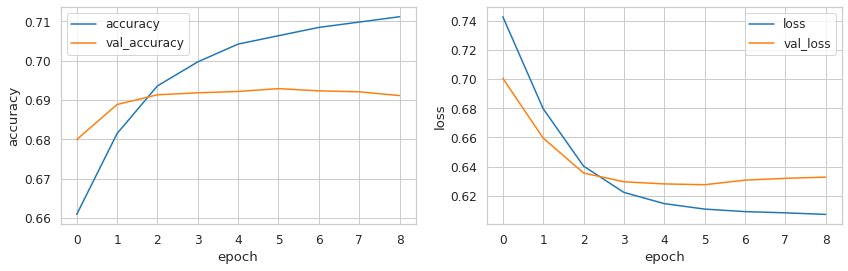

In [52]:
plot_history(fit)

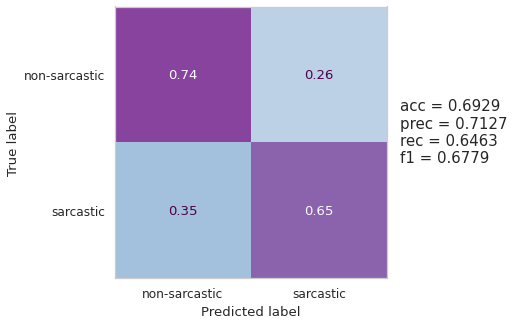

In [53]:
evaluate(model, sparse_tensor(X_val_vec), y_val)

In [54]:
show_errors(model, X_val['comment'].values, sparse_tensor(X_val_vec), y_val,
            X_parents=X_val['parent_comment'].values)

False negatives:
---------------------------
parent: A friend had a laser treatment on his wart today.
comment: Just hit it again!

parent: So I went to a japanese steakhouse for my dad's birthday and they made him wear this...
comment: Simply horrifiying.

parent: OMG xxallcapsxx ! That poor little..wait! Nice job there Dad....
comment: Never too early for a bikini.

parent: Possible issue with Hitreg, Needs Clarification
comment: Source xxnumberxx is just around the corner which will fix the issue.

parent: New account - only post - Instagram celeb. Smells like self promotion.
comment: Let's lynch him.


False positives:
---------------------------
parent: Bigger than nme, tdk, txxnumberxx dig, and possibly even tip or gv. Yeah I'd want that kind of viewership if I were Gamespot. But to be fair, I don't think any team will ever get anywhere close to TSM xxallcapsxx .
comment: Yeah, even with RNG xxallcapsxx 's popularity, TSM xxallcapsxx  is the holy grail of NA xxallcapsxx  playerba

In [55]:
model.save(root+'models/context_bag_of_words')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_bag_of_words/assets
